In [28]:
# 1. Import libraries
import earthaccess
import rasterio
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from datetime import datetime
import geopandas as gp
from shapely.geometry import Point as p
import os
import joblib

In [2]:
# 2. Authenticate with Earthaccess
auth = earthaccess.login()

In [3]:
# 3. Search for MODIS NDVI data for a region (example: Kenya, 2022–2023)
results = earthaccess.search_data(
    short_name="MOD13Q1",    # MODIS Vegetation Indices
    bounding_box=(34, -4, 42, 4),   # kenya
    temporal=("2024-06-01", "2024-12-31")
)

In [9]:
# 4. Download a small subset
files = earthaccess.download(results, "./data")

NameError: name 'results' is not defined

In [10]:
data_dir = Path("./converted")
# files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".tif")])
files = sorted(data_dir.glob("*.tif"))

In [11]:
ndvi_means = []
ndvi_stack = []
dates = []

for f in files:
    with rasterio.open(f) as src:
        ndvi = src.read(1).astype(float)
        ndvi[ndvi == src.nodata] = np.nan
        
        ndvi_stack.append(ndvi)
        # Apply MODIS scale factor
        ndvi = ndvi * 0.0001  

        # Mask out invalid values
        ndvi[ndvi < -0.2] = np.nan
        ndvi[ndvi > 1.0] = np.nan

        ndvi_mean = np.nanmean(ndvi)
        ndvi_means.append(ndvi_mean)

    # Extract date from filename (AYYYYDDD pattern)
    match = re.search(r"A(\d{7})", f.name)
    if match:
        doy = match.group(1)  # '2021353'
        dt = datetime.strptime(doy, "%Y%j")
        dates.append(dt)

print("NDVI means:", ndvi_means)

NDVI means: [0.5858672118466101, 0.5912985804718891, 0.40071624998244265, 0.5716079830920473, 0.5879273228038456, 0.5468756077866197, 0.3483140219950294, 0.5539664897733672, 0.5667734881300073, 0.49303245247331984, 0.30666458016428844, 0.49846468121726306, 0.464457794853212, 0.28482825788723787, 0.46202331745504704, 0.42356113664214623, 0.4648988177960345, 0.415490692905518, 0.615231189137803, 0.2821880723415601, 0.4511522510141803, 0.28785520621768007, 0.43002047993122294, 0.5755205526089864, 0.385647030793406, 0.389796066290733, 0.5884201065553604, 0.3091839954291483, 0.39978542687066965, 0.5933896913496411, 0.4431587514797303, 0.3497615545097242, 0.40290893230568126, 0.585742227307354, 0.47021059704870866, 0.37083766776571186, 0.5679482888813143, 0.5713881984734622, 0.5734927322612513, 0.34042751337095273, 0.5787476273741627, 0.4881592185239582, 0.29100445061622865, 0.5074489771911493]


In [12]:
print(f"loaded {len(ndvi_stack)} NDVI rasters for {len(dates)} dates.")

loaded 44 NDVI rasters for 44 dates.


In [13]:
# 7. Detect anomalies (potential invasive events)
ndvi_series = pd.Series(ndvi_means, index=pd.to_datetime(dates))

rolling_mean = ndvi_series.rolling(window=3, center=True).mean()

anomalies = ndvi_series.nlargest(10)

print("Anomalies: ", anomalies)

Anomalies:  2024-08-28    0.615231
2024-10-31    0.593390
2024-05-24    0.591299
2024-10-15    0.588420
2024-06-09    0.587927
2024-05-24    0.585867
2024-11-16    0.585742
2024-12-02    0.578748
2024-09-29    0.575521
2024-12-02    0.573493
dtype: float64


In [14]:
coords_list = []

with rasterio.open(files[-1]) as src:
    ndvi = src.read(1).astype(float)
    ndvi = ndvi * 0.0001
    ndvi[(ndvi < -0.2) | (ndvi > 1.0)] = np.nan  # mask invalids
    
    # Get affine transform and grid dimensions
    transform = src.transform
    rows, cols = np.where(~np.isnan(ndvi))
    
    for r, c in zip(rows, cols):
        lon, lat = rasterio.transform.xy(transform, r, c)
        coords_list.append({
            "lon": lon,
            "lat": lat,
            "ndvi": float(ndvi[r, c])
        })

# Convert to GeoDataFrame
gdf = gp.GeoDataFrame(coords_list, geometry=gp.points_from_xy(
    [d["lon"] for d in coords_list],
    [d["lat"] for d in coords_list]
), crs="EPSG:4326")

gdf.head()


,lon,lat,ndvi,geometry
0,4.447918e+06,-115.828179,0.2883,POINT (4447917.90685 -115.82818)
1,4.448150e+06,-115.828179,0.2586,POINT (4448149.5632 -115.82818)
2,4.448381e+06,-115.828179,0.2705,POINT (4448381.21956 -115.82818)
3,4.448613e+06,-115.828179,0.2556,POINT (4448612.87592 -115.82818)
4,4.448845e+06,-115.828179,0.3667,POINT (4448844.53228 -115.82818)


In [16]:
# Prepare output for MongoDB (spatial NDVI data)
heatmap_json = [
    {"lat": row.lat, "lon": row.lon, "ndvi": row.ndvi}
    for _, row in gdf.iterrows()
]

# Compute NDVI mean for each file and attach date (temporal NDVI summary)
ndvi_df = pd.DataFrame({
    "date": dates,
    "mean_ndvi": ndvi_means
})

# Combine both datasets into one exportable structure
export_data = {
    "spatial_data": heatmap_json,
    "temporal_summary": ndvi_df.to_dict(orient="records")
}

# Save everything as one JSON file for inspection or MongoDB upload
import json
with open("ndvi_combined.json", "w") as f:
    json.dump(export_data, f, indent=2, default=str)

print("✅ NDVI combined data ready for MongoDB or React frontend.")
print(f"Spatial records: {len(heatmap_json)} | Temporal records: {len(ndvi_df)}")


✅ NDVI combined data ready for MongoDB or React frontend.
Spatial records: 1075372 | Temporal records: 44


In [17]:
# --- Anomalies section ---
anomalies_df = anomalies.reset_index()
anomalies_df.columns = ["date", "ndvi_value"]

# Convert anomalies to dict
anomalies_json = anomalies_df.to_dict(orient="records")

# --- Final Export ---
export_data = {
    "spatial_data": heatmap_json,
    "temporal_summary": ndvi_df.to_dict(orient="records"),
    "anomalies": anomalies_json
}

# Save as JSON
with open("ndvi_with_anomalies_combined.json", "w") as f:
    json.dump(export_data, f, indent=2, default=str)

print(f"✅ NDVI combined data ready for MongoDB or React frontend.")
print(f"Spatial records: {len(heatmap_json)} | Temporal: {len(ndvi_df)} | Anomalies: {len(anomalies_json)}")


✅ NDVI combined data ready for MongoDB or React frontend.
Spatial records: 1075372 | Temporal: 44 | Anomalies: 10


Model Creation

In [18]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [19]:
# --- Build Training Data ---

# Suppose we merge spatial + temporal mean data
# (you could merge them by date or approximate date)
temporal_mean = ndvi_df.copy()
temporal_mean["timestamp"] = temporal_mean["date"].map(datetime.toordinal)
temporal_mean["lat"] = np.random.uniform(-4, 4, len(temporal_mean))      # approximate Kenyan latitudes
temporal_mean["lon"] = np.random.uniform(34, 42, len(temporal_mean))     # approximate Kenyan longitudes

X = temporal_mean[["lat", "lon", "timestamp"]]
y = temporal_mean["mean_ndvi"]

In [20]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:

# --- Train Model ---
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# --- Evaluate ---
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R²: -0.583589238760291
MAE: 0.08690751916361432


In [26]:
# --- Predict Future NDVI ---
future_dates = pd.date_range("2025-06-01", "2025-12-31", freq="16D")
future_df = pd.DataFrame({
    "timestamp": [d.toordinal() for d in future_dates],
    "lat": np.random.uniform(-4, 4, len(future_dates)),
    "lon": np.random.uniform(34, 42, len(future_dates))
})

future_X = scaler.transform(future_df[["lat", "lon", "timestamp"]])
future_df["predicted_ndvi"] = model.predict(future_X)


In [27]:
# --- Add to JSON Export ---
future_json = future_df.to_dict(orient="records")

export_data["predictions"] = future_json

with open("ndvi_combined.json", "w") as f:
    json.dump(export_data, f, indent=2, default=str)

print(f"✅ Added {len(future_json)} future predictions.")


✅ Added 14 future predictions.


In [29]:
# 3. Save/export the model
joblib.dump(model, "ndvi_predictor.pkl")
print("Model saved as ndvi_predictor.pkl")

Model saved as ndvi_predictor.pkl


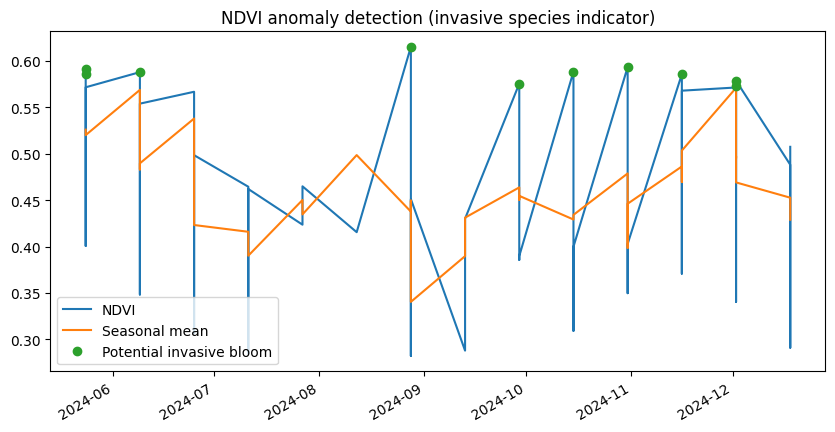

In [11]:
# 8. Plot results
plt.figure(figsize=(10,5))
ndvi_series.plot(label="NDVI")
rolling_mean.plot(label="Seasonal mean")
anomalies.plot(style="o", label="Potential invasive bloom")
plt.legend()
plt.title("NDVI anomaly detection (invasive species indicator)")
plt.show()
